In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/userdatasets/GE61y.csv
/kaggle/input/userdataset2/A9K1000-ESP100.csv


In [2]:
df = pd.read_csv('/kaggle/input/userdataset2/A9K1000-ESP100.csv')
print(df.head())

  Business Unit Product Family            PLID Fiscal Quarter Fiscal Month  \
0         SRSBU        A9K1000  A9K1000-ESP100      Q2 FY2013   JAN FY2013   
1         SRSBU        A9K1000  A9K1000-ESP100      Q3 FY2013   FEB FY2013   
2         SRSBU        A9K1000  A9K1000-ESP100      Q3 FY2013   MAR FY2013   
3         SRSBU        A9K1000  A9K1000-ESP100      Q3 FY2013   APR FY2013   
4         SRSBU        A9K1000  A9K1000-ESP100      Q4 FY2013   MAY FY2013   

   Booked_Qty Booking_Date  
0          63   2013-01-01  
1          31   2013-02-01  
2          61   2013-03-01  
3         104   2013-04-01  
4          19   2013-05-01  


In [3]:
train_dates = pd.to_datetime(df['Booking_Date'])
print(train_dates.tail(15))

99    2021-04-01
100   2021-05-01
101   2021-06-01
102   2021-07-01
103   2021-08-01
104   2021-09-01
105   2021-10-01
106   2021-11-01
107   2021-12-01
108   2022-01-01
109   2022-08-01
110   2022-09-01
111   2022-10-01
112   2022-11-01
113   2022-12-01
Name: Booking_Date, dtype: datetime64[ns]


In [4]:
cols = list(df)[5:6]
print(cols) 

['Booked_Qty']


In [5]:
df_for_training = df[cols].astype(float)

In [6]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled.shape

(114, 1)

In [13]:
trainX = []
trainY = []

n_future = 1  
n_past = 14  
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (100, 14, 1).
trainY shape == (100, 1).


In [14]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

In [15]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
6/6 [==============================] - 3s 92ms/step - loss: 1.0267 - val_loss: 0.4891
Epoch 2/50
6/6 [==============================] - 0s 17ms/step - loss: 1.0044 - val_loss: 0.5069
Epoch 3/50
6/6 [==============================] - 0s 19ms/step - loss: 0.9852 - val_loss: 0.5399
Epoch 4/50
6/6 [==============================] - 0s 18ms/step - loss: 0.9513 - val_loss: 0.5826
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 0.9178 - val_loss: 0.6603
Epoch 6/50
6/6 [==============================] - 0s 23ms/step - loss: 0.9356 - val_loss: 0.7452
Epoch 7/50
6/6 [==============================] - 0s 19ms/step - loss: 0.9100 - val_loss: 0.9594
Epoch 8/50
6/6 [==============================] - 0s 20ms/step - loss: 0.8763 - val_loss: 0.9381
Epoch 9/50
6/6 [==============================] - 0s 19ms/step - loss: 0.8935 - val_loss: 1.0117
Epoch 10/50
6/6 [==============================] - 0s 20ms/step - loss: 0.8596 - val_loss: 0.9194
Epoch 11/50
6/6 [============

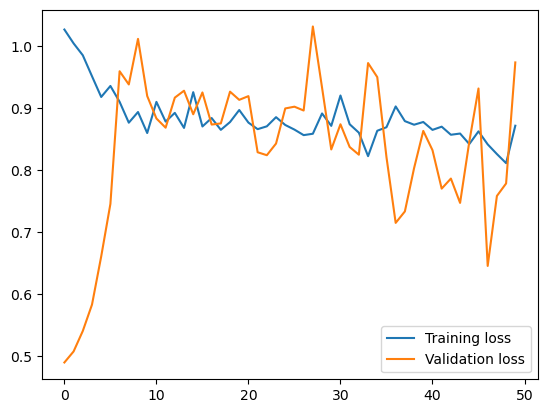

In [16]:
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [17]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [26]:
n_past = 5
n_days_for_prediction=5
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq='MS').tolist()
print(predict_period_dates)

[Timestamp('2022-08-01 00:00:00', freq='MS'), Timestamp('2022-09-01 00:00:00', freq='MS'), Timestamp('2022-10-01 00:00:00', freq='MS'), Timestamp('2022-11-01 00:00:00', freq='MS'), Timestamp('2022-12-01 00:00:00', freq='MS')]


In [27]:
prediction = model.predict(trainX[-5:])

1/1 [==============================] - 0s 27ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


<AxesSubplot:xlabel='Booking_Date', ylabel='Booked_Qty'>

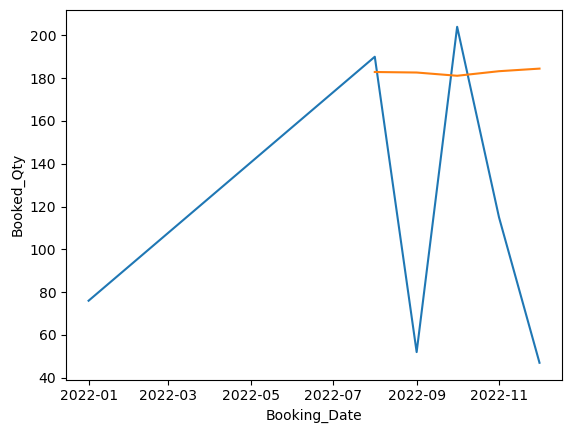

In [28]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Booking_Date':np.array(forecast_dates), 'Booked_Qty':y_pred_future})
df_forecast['Booking_Date']=pd.to_datetime(df_forecast['Booking_Date'])


original = df[['Booking_Date', 'Booked_Qty']]
original['Booking_Date']=pd.to_datetime(original['Booking_Date'])
original = original.loc[original['Booking_Date'] >= '2022-01-1']

sns.lineplot(x="Booking_Date",y="Booked_Qty",data=original)
sns.lineplot(x="Booking_Date",y="Booked_Qty",data=df_forecast)

In [ ]:
x_input = 
temp_input=list(x_input)
lst_output=[]
i=0
while(i<10):
    
    if(len(temp_input)>3):
        x_input=array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

print(lst_output)